## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.** 

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo). 



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder). 

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

### Step 1: Loading the MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Normalize the data
X = X / 255.0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to proper shape and type for PyTorch or TensorFlow
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)


/home/tim/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Step 2: Building the VAE Model

In [6]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, 512)
        self.mu = nn.Linear(512, latent_dim)
        self.log_var = nn.Linear(512, latent_dim)
    
    def forward(self, x):
        x = torch.relu(self.linear(x))
        return self.mu(x), self.log_var(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 512)
        self.out = nn.Linear(512, output_dim)
    
    def forward(self, z):
        z = torch.relu(self.linear(z))
        return torch.sigmoid(self.out(z))


Encoder is a class defining the encoder part of the VAE.
It first maps the input to a hidden layer of size 512.
mu and log_var are two fully connected layers that output the mean and log-variance of the latent space distribution.

Decoder is a class defining the decoder part of the VAE.
It maps the latent space representation back to the original data space.
The final output is passed through a sigmoid function to get values between 0 and 1, suitable for MNIST image reconstruction.

In [7]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

### Step 3: Loss Function for VAE

The VAE loss function comprises two parts: the reconstruction loss and the KL divergence. The reconstruction loss measures how well the decoded samples match the original inputs, and the KL divergence measures how closely the learned latent variable distribution matches the prior distribution

In [8]:
def vae_loss(reconstructed_x, original_x, mu, log_var):
    # Reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x, original_x, reduction='sum')

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return reconstruction_loss + kl_divergence


### Step 4: Training the VAE

Epoch [1/10], Train Loss: 180.1322, Test Loss: 166.4009
Epoch [2/10], Train Loss: 163.7564, Test Loss: 161.3477
Epoch [3/10], Train Loss: 160.2261, Test Loss: 158.7007
Epoch [4/10], Train Loss: 158.3027, Test Loss: 156.8900
Epoch [5/10], Train Loss: 156.8387, Test Loss: 155.9798
Epoch [6/10], Train Loss: 155.7281, Test Loss: 154.8899
Epoch [7/10], Train Loss: 154.6868, Test Loss: 154.3369
Epoch [8/10], Train Loss: 153.8085, Test Loss: 153.8479
Epoch [9/10], Train Loss: 153.0415, Test Loss: 152.9837
Epoch [10/10], Train Loss: 152.3215, Test Loss: 152.6153


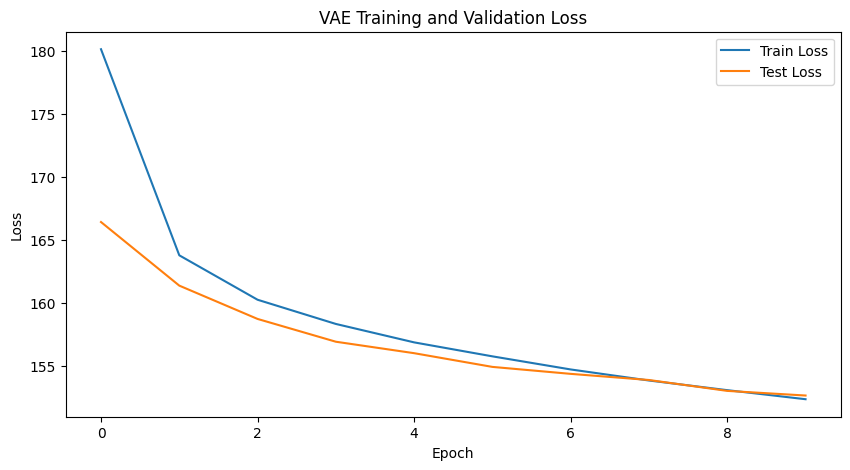

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 2  
learning_rate = 0.001 
num_epochs = 10  # Number of epochs

# Convert numpy arrays to PyTorch tensors and create data loaders
train_tensor = torch.tensor(X_train)
train_dataset = TensorDataset(train_tensor, train_tensor)  # input and target are the same
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_tensor = torch.tensor(X_test)
test_dataset = TensorDataset(test_tensor, test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the Encoder and Decoder
encoder = Encoder(input_dim=784, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, output_dim=784)

# Optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Training loop
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_train_loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784)
        optimizer.zero_grad()

        # Forward pass
        mu, log_var = encoder(batch_features)
        z = reparameterize(mu, log_var)
        reconstructed = decoder(z)

        # Loss computation
        loss = vae_loss(reconstructed, batch_features, mu, log_var)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Record average train loss
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_loss.append(avg_train_loss)

    # Validation loop
    encoder.eval()
    decoder.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.view(-1, 784)

            # Forward pass
            mu, log_var = encoder(batch_features)
            z = reparameterize(mu, log_var)
            reconstructed = decoder(z)

            # Loss computation
            loss = vae_loss(reconstructed, batch_features, mu, log_var)
            total_test_loss += loss.item()
    
    # Record average test loss
    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_loss.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Validation Loss')
plt.legend()
plt.show()


### Step 5: Visualization of Latent Space

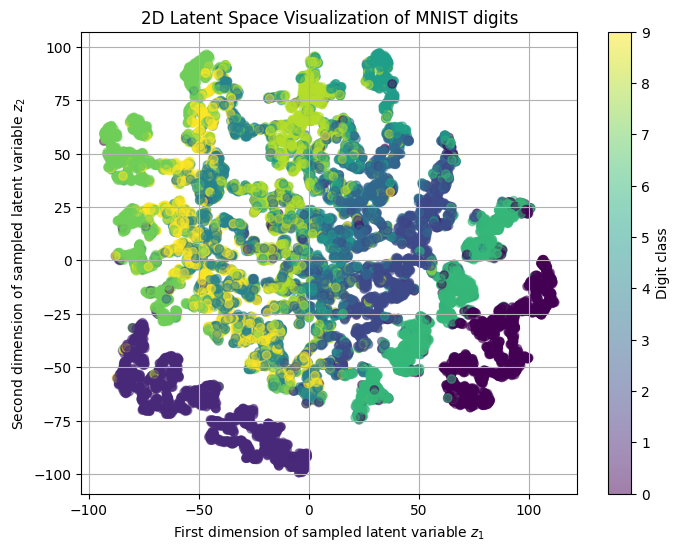

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# First, we pass our test data through the encoder
mu, log_var = encoder(torch.from_numpy(X_test).float())
z = reparameterize(mu, log_var).detach().numpy()

# We can use t-SNE to reduce the dimensionality of the latent variables to 2D for visualization
z_embedded = TSNE(n_components=2).fit_transform(z)

# Plotting each point in the 2D latent space, colored by its digit class
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y_test.astype(int), cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Digit class')
plt.xlabel('First dimension of sampled latent variable $z_1$')
plt.ylabel('Second dimension of sampled latent variable $z_2$')
plt.title('2D Latent Space Visualization of MNIST digits')
plt.grid(True)
plt.show()


### Step 6: Generating Images from Latent Space

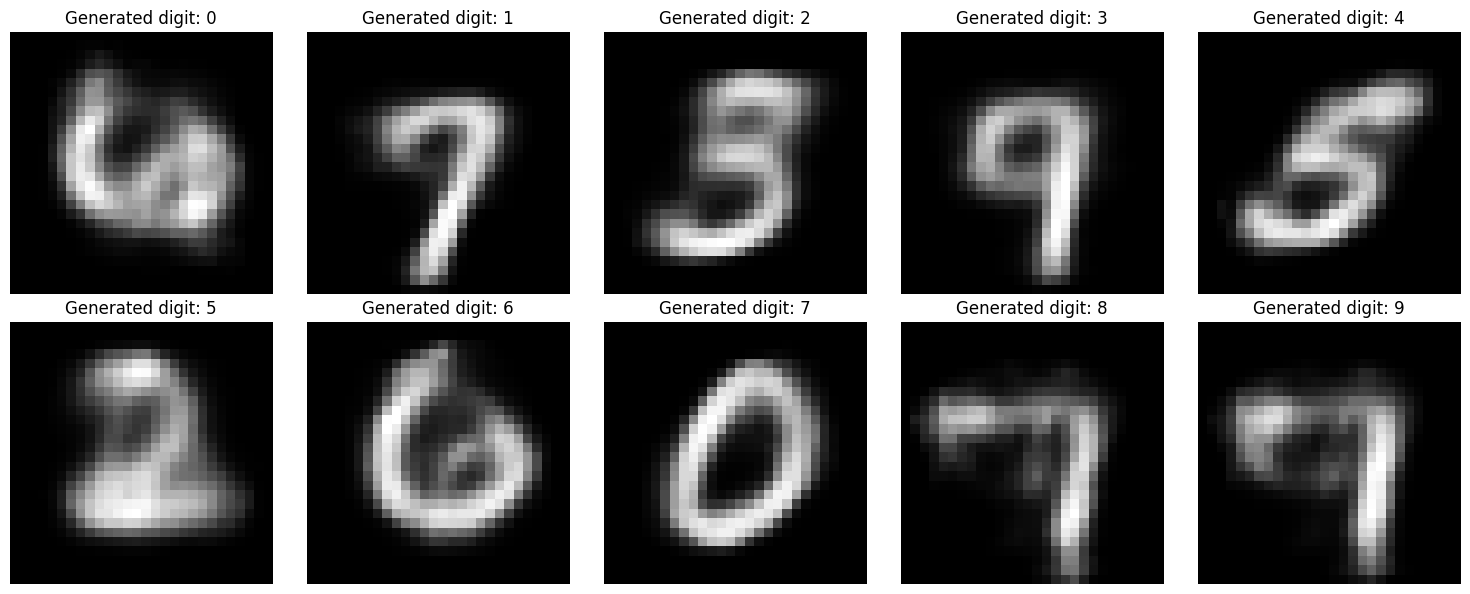

In [11]:
def generate_digit(decoder, latent_dim, digit):
    # Sample from the standard normal distribution
    z_sample = torch.randn(1, latent_dim)
    
    # Generate a digit image from the sampled latent vector
    generated_digit = decoder(z_sample).view(28, 28).detach().numpy()

    return generated_digit

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Generate and display images for digits 0-9
for digit in range(10):
    # Obtain a generated digit image
    generated_image = generate_digit(decoder, latent_dim, digit)
    
    # Plot the generated image
    ax = axes[digit // 5, digit % 5]
    ax.imshow(generated_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated digit: {digit}')

plt.tight_layout()
plt.show()
